# Load the data set

In [4]:
import yfinance as yf
import pandas as pd

# Assuming the data sample is loaded into a DataFrame `df`
df = pd.read_csv('../data/cleaned_data.csv')
# Check the column names to ensure the correct reference
print(df.columns)
# Select the correct column for Tesla (TSLA)
df_tsla = df['Adj Close.2']

# Check the first few rows to ensure it’s the correct data
print(df_tsla.head())


Index(['Adj Close', 'Adj Close.1', 'Adj Close.2', 'Close', 'Close.1',
       'Close.2', 'High', 'High.1', 'High.2', 'Low', 'Low.1', 'Low.2', 'Open',
       'Open.1', 'Open.2', 'Volume', 'Volume.1', 'Volume.2'],
      dtype='object')
0                  TSLA
1    14.620667457580566
2    14.005999565124512
3    14.085332870483398
4    14.063332557678223
Name: Adj Close.2, dtype: object


# Proceed with the Preprocessing Steps

### Handle missing values

In [5]:
# Check for missing values in Tesla's Adjusted Close Price
print(df_tsla.isnull().sum())

# If there are missing values, fill them forward
df_tsla.fillna(method='ffill', inplace=True)


0


C:\Users\wubeshet.abera\AppData\Local\Temp\ipykernel_19364\2843280530.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_tsla.fillna(method='ffill', inplace=True)


### Visualize the Tesla Data:

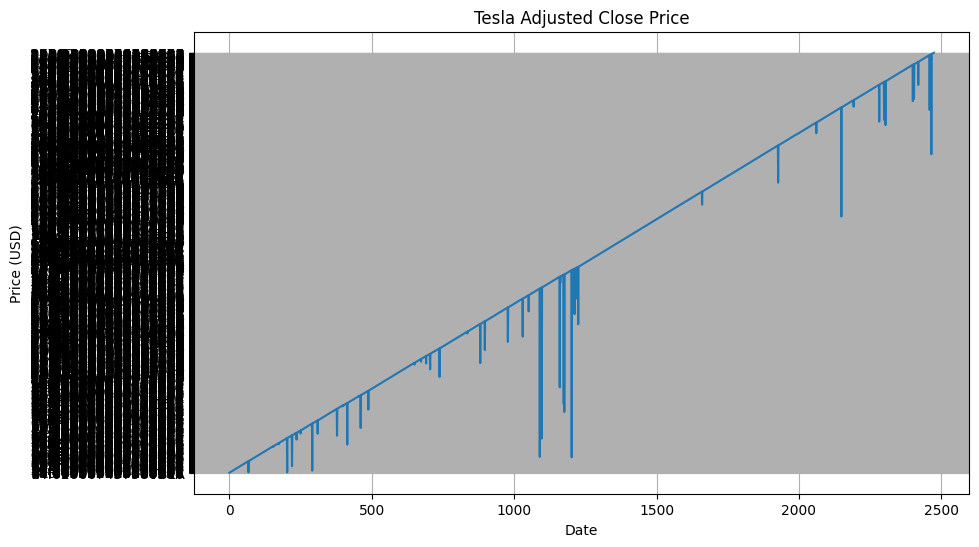

In [6]:
import matplotlib.pyplot as plt

# Plot Tesla's Adjusted Close Price
plt.figure(figsize=(10, 6))
plt.plot(df_tsla)
plt.title('Tesla Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


### Split the Data into Training and Testing Sets:

In [7]:
# Split the data into training (80%) and testing (20%) sets
train_size = int(len(df_tsla) * 0.8)
train, test = df_tsla[:train_size], df_tsla[train_size:]

print(f'Training data size: {len(train)}')
print(f'Testing data size: {len(test)}')


Training data size: 1980
Testing data size: 495


In [8]:
print(df_tsla.dtype)
df_tsla.fillna(method='bfill', inplace=True)

df_tsla.dropna(inplace=True)

print(df_tsla.isnull().sum())  # Should return 0 if all NaNs are handled


object
0


C:\Users\wubeshet.abera\AppData\Local\Temp\ipykernel_19364\3002617639.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_tsla.fillna(method='bfill', inplace=True)


In [9]:
# Ensure that the data is numeric and handle any conversion errors
df_tsla = df_tsla.apply(pd.to_numeric, errors='coerce')

# Check for NaN values and handle them (drop or fill)
df_tsla = df_tsla.dropna()  # or use df_tsla = df_tsla.fillna(method='ffill') to forward-fill

# Check the data types to confirm all columns are numeric
print(df_tsla.dtypes)

# Now proceed with the model training and forecasting
# Split the data into training (80%) and testing (20%) sets
train_size = int(len(df_tsla) * 0.8)
train, test = df_tsla[:train_size], df_tsla[train_size:]

print(f'Training data size: {len(train)}')
print(f'Testing data size: {len(test)}')


float64
Training data size: 1979
Testing data size: 495


### Train an ARIMA Model:

In [10]:
# Fit the ARIMA model on the training set
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Generate forecast for the test data
forecast = model_fit.forecast(steps=len(test))

# Evaluate model as before
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")


c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, f

MAE: 39.313251915978014, RMSE: 49.56620023420207, MAPE: 17.742177776419606%


c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

# Define parameter grid for ARIMA
p = d = q = range(0, 3)
parameters = list(itertools.product(p, d, q))

# Grid search for ARIMA
best_aic = float("inf")
best_order = None
best_model = None

for param in parameters:
    try:
        model = ARIMA(df_tsla, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = param
            best_model = model_fit
    except Exception as e:
        continue

print(f'Best ARIMA order: {best_order}')
print(f'AIC: {best_aic}')


c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, f

Best ARIMA order: (1, 1, 0)
AIC: 15827.423504326607


# SARIMA (Seasonal ARIMA)

c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          Adj Close.2   No. Observations:                 2474
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 30)   Log Likelihood               -7771.415
Date:                              Tue, 12 Nov 2024   AIC                          15558.830
Time:                                      08:19:38   BIC                          15605.123
Sample:                                           0   HQIC                         15575.669
                                             - 2474                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0280      0.013     -2.198      0.028      -0.053      -0.003
ar.L2          0.00

c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


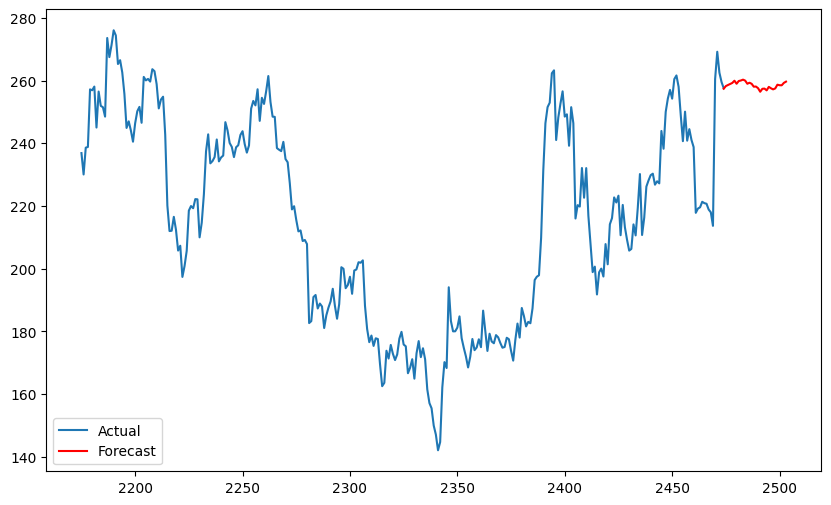

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA: SARIMAX(p, d, q)(P, D, Q, S)
# p, d, q are the non-seasonal parameters, P, D, Q are the seasonal ones, and S is the seasonal period
# Example: p=5, d=1, q=0, P=1, D=1, Q=1, S=252 (seasonal cycle for daily stock data)

seasonal_order = (1, 1, 1, 30)  # Adjust the seasonal period as needed
model_sarima = SARIMAX(df_tsla,
                       order=(5, 1, 0),
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
model_sarima_fit = model_sarima.fit()

# Print summary
print(model_sarima_fit.summary())

# Forecasting
forecast = model_sarima_fit.get_forecast(steps=30)  # Forecast for the next 30 days
forecast_values = forecast.predicted_mean

# Plot the actual vs forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_tsla.index[-300:], df_tsla[-300:], label='Actual')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.legend()
plt.show()


# LSTM (Long Short-Term Memory)


c:\Users\wubeshet.abera\Projects\Ten-Academy\GMF-Portfolio-Forecasting\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0422
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.1863e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.8299e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.3838e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.9473e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.5590e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.9080e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.0855e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.1326e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


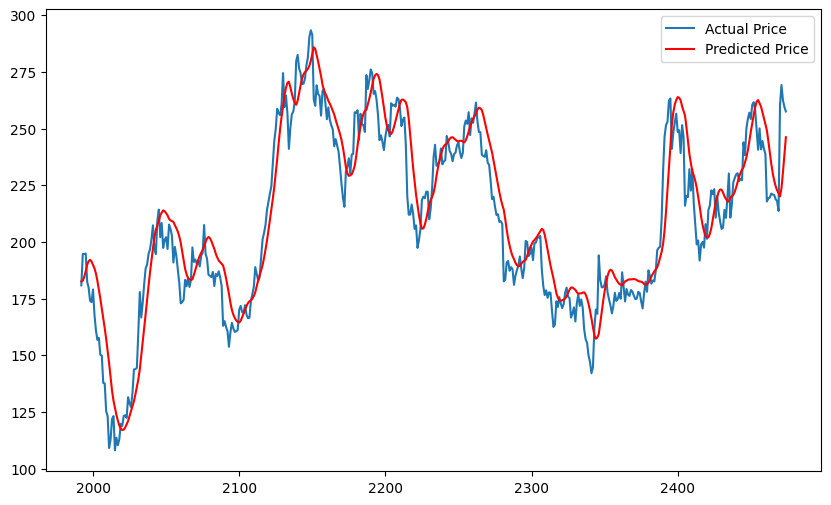

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_tsla_scaled = scaler.fit_transform(df_tsla.values.reshape(-1, 1))

# Create a dataset for LSTM: create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 60  # Use past 60 days to predict the next day
X = create_sequences(df_tsla_scaled, sequence_length)
y = df_tsla_scaled[sequence_length:]

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
predicted_stock_price = model_lstm.predict(X_test)

# Inverse transform to get the actual prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_tsla.index[-len(y_test_actual):], y_test_actual, label='Actual Price')
plt.plot(df_tsla.index[-len(y_test_actual):], predicted_stock_price, label='Predicted Price', color='red')
plt.legend()
plt.show()
